<a href="https://colab.research.google.com/github/sohiniroych/BioBERT_Named_Entity_Recognition/blob/main/Named_Entity_Recognition_BC5CDR_for_medical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition on BC5CDR (Chemical + Disease Corpus) with BioBERT

---
**This is a modification to Bidirectional Encoder Representations from Transformers (BERT) for medical jargon.**

This assignment is based on: [Github](https://github.com/eugenesiow/practical-ml/blob/master/notebooks/Named_Entity_Recognition_Mandarin_MSRA.ipynb)
---

Notebook to train/fine-tune a BioBERT model to perform named entity recognition (NER). 

The [dataset](https://github.com/shreyashub/BioFLAIR/tree/master/data/ner/bc5cdr) used is a pre-processed version of the BC5CDR (BioCreative V CDR task corpus: a resource for  relation extraction) dataset from [Li et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27161011/).

The current state-of-the-art model on this dataset is the NER+PA+RL model from [Nooralahzadeh et al. (2019)](https://www.aclweb.org/anthology/D19-6125/) has an F1-score of [**89.93%**](https://paperswithcode.com/sota/named-entity-recognition-ner-on-bc5cdr). The authors did not release the source code for the paper.

The notebook is structured as follows:
* Setting up the GPU Environment
* Getting Data
* Training and Testing the Model
* Using the Model (Running Inference)

#### Task Description

> Named entity recognition (NER) is the task of tagging entities in text with their corresponding type. Approaches typically use BIO notation, which differentiates the beginning (B) and the inside (I) of entities. O is used for non-entity tokens.

# Setting up the GPU Environment

#### Ensure we have a GPU runtime

If you're running this notebook in Google Colab, select `Runtime` > `Change Runtime Type` from the menubar. Ensure that `GPU` is selected as the `Hardware accelerator`. This will allow us to use the GPU to train the model subsequently.

#### Install Dependencies and Restart Runtime

In [1]:
!pip install -q transformers
!pip install -q simpletransformers

     |████████████████████████████████| 3.5 MB 11.4 MB/s 
     |████████████████████████████████| 6.8 MB 35.8 MB/s 
     |████████████████████████████████| 895 kB 22.0 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 28.6 MB/s 
     |████████████████████████████████| 248 kB 10.5 MB/s 
     |████████████████████████████████| 1.2 MB 37.4 MB/s 
     |████████████████████████████████| 9.7 MB 22.7 MB/s 
     |████████████████████████████████| 311 kB 53.1 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 1.7 MB 35.8 MB/s 
     |████████████████████████████████| 144 kB 45.4 MB/s 
     |████████████████████████████████| 181 kB 15.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 212 kB 36.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.1 MB/s 
     |████████████████████████████████| 134 kB 55.3 MB/s 
     |██████████████

You might see the error `ERROR: google-colab X.X.X has requirement ipykernel~=X.X, but you'll have ipykernel X.X.X which is incompatible` after installing the dependencies. **This is normal** and caused by the `simpletransformers` library.

The **solution** to this will be to **reset the execution environment** now. Go to the menu `Runtime` > `Restart runtime` then continue on from the next section to download and process the data.

# Getting Data

#### Pulling the data from Github

The dataset, includes train, test and dev sets, which we pull from the [Github repository](https://github.com/shreyashub/BioFLAIR/tree/master/data/ner/bc5cdr).

In [2]:
import urllib.request
from pathlib import Path

def download_file(url, output_file):
  Path(output_file).parent.mkdir(parents=True, exist_ok=True)
  urllib.request.urlretrieve (url, output_file)

download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/train.txt', '/content/data/train.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/test.txt', '/content/data/test.txt')
download_file('https://raw.githubusercontent.com/shreyashub/BioFLAIR/master/data/ner/bc5cdr/dev.txt', '/content/data/dev.txt')

Since the data is formatted in the CoNLL `BIO` type format (you can read more on the tagging format from this [wikipedia article](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))), we need to format it into a `pandas` dataframe with the following function. The 3 important columns in the dataframe are a word token (for mandarin this is a single character), a `BIO` label and a sentence_id to differentiate samples/sentences.

In [3]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

Now we execute the function on the train, test and dev sets we have downloaded from Github. We also `.head()` the training set dataframe for the first 100 rows to check that the words, labels and sentence_id have been split properly.

In [4]:
train_df = read_conll('/content/data/train.txt')
test_df = read_conll('/content/data/test.txt')
dev_df = read_conll('/content/data/dev.txt')
train_df.head(100)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
...,...,...,...,...,...
102,not,ADV,O,O,6
103,influence,VERB,O,O,6
104,stereoselective,ADJ,O,O,6
105,binding,NOUN,O,O,6


['B-Entity' 'I-Entity' 'O']


(array([10931.,     0.,     0.,     0.,     0., 82026.,     0.,     0.,
            0.,  2413.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic nor

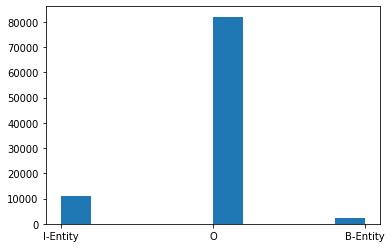

In [9]:
import numpy as np
import matplotlib.pyplot as plt
print(np.unique(train_df['labels']))
plt.hist(train_df['labels'])


We now print out the statistics (number of sentences) of the train, dev and test sets.

In [5]:
data = [[train_df['sentence_id'].nunique(), test_df['sentence_id'].nunique(), dev_df['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,3942,4139,3949


# Training and Testing the Model

#### Set up the Training Arguments

We set up the training arguments. Here we train to 10 epochs to get accuracy close to the SOTA. The train, test and dev sets are relatively small so we don't have to wait too long. We set a sliding window as NER sequences can be quite long and because we have limited GPU memory we can't increase the `max_seq_length` too long.

In [6]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 5,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}

The following line of code saves (to the variable `custom_labels`) a set of all the NER tags/labels in the dataset.

#### Train the Model

Once we have setup the `train_args` dictionary, the next step would be to train the model. We use the pre-trained BioBERT model (by [DMIS Lab, Korea University](https://huggingface.co/dmis-lab)) from the awesome [Hugging Face Transformers](https://github.com/huggingface/transformers) library as the base and use the [Simple Transformers library](https://simpletransformers.ai/docs/classification-models/) on top of it to make it so we can train the NER (sequence tagging) model with just a few lines of code.

In [8]:
from simpletransformers.ner import NERModel
from transformers import AutoTokenizer
import pandas as pd
import logging

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the bio BERT pre-trained model.
model = NERModel('bert', 'dmis-lab/biobert-v1.1', labels=custom_labels, args=train_args)

# Train the model
# https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
history=model.train_model(train_df, eval_data=dev_df)

# Evaluate the model in terms of accuracy score
result, model_outputs, preds_list = model.eval_model(test_df)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140666568777104 on /root/.cache/huggingface/transformers/f048b8136bae2b3abe91e9e82949295fb205887c84db3be2775e1cdb0ecfeeb9.d7812d36d3371e4d43299a0c4a938622c5251db0efa17a5d4d9b57037fcec823.lock
DEBUG:filelock:Lock 140666568777104 acquired on /root/.cache/huggingface/transformers/f048b8136bae2b3abe91e9e82949295fb205887c84db3be2775e1cdb0ecfeeb9.d7812d36d3371e4d43299a0c4a938622c5251db0efa17a5d4d9b57037fcec823.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dmis-lab/biobert-v1.1/resolve/main/config.json HTTP/1.1" 200 462


Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140666568777104 on /root/.cache/huggingface/transformers/f048b8136bae2b3abe91e9e82949295fb205887c84db3be2775e1cdb0ecfeeb9.d7812d36d3371e4d43299a0c4a938622c5251db0efa17a5d4d9b57037fcec823.lock
DEBUG:filelock:Lock 140666568777104 released on /root/.cache/huggingface/transformers/f048b8136bae2b3abe91e9e82949295fb205887c84db3be2775e1cdb0ecfeeb9.d7812d36d3371e4d43299a0c4a938622c5251db0efa17a5d4d9b57037fcec823.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 140666569197904 on /root/.cache/huggingface/transformers/65231a5792b14eb81b9a6bdccccfffda18575eb3bafbb730c9fa4235e56c3c17.74cc2087932cb523a583bd5e65732ee1aaade59dfc0b62f88101de7567d92e42.lock
DEBUG:filelock:Lock 140666569197904 acquired on /root/.cache/huggingface/transformers/65231a5792

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140666569197904 on /root/.cache/huggingface/transformers/65231a5792b14eb81b9a6bdccccfffda18575eb3bafbb730c9fa4235e56c3c17.74cc2087932cb523a583bd5e65732ee1aaade59dfc0b62f88101de7567d92e42.lock
DEBUG:filelock:Lock 140666569197904 released on /root/.cache/huggingface/transformers/65231a5792b14eb81b9a6bdccccfffda18575eb3bafbb730c9fa4235e56c3c17.74cc2087932cb523a583bd5e65732ee1aaade59dfc0b62f88101de7567d92e42.lock
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acq

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140666568371344 on /root/.cache/huggingface/transformers/2fb6c5805404829e9c10c33b38ae59ae3011225799f3177f769a06a7411fa46c.25d8d06fb0679146a3ed2a3463e3585380bff882fe6e1ebc497196e40dbbd7fa.lock
DEBUG:filelock:Lock 140666568371344 released on /root/.cache/huggingface/transformers/2fb6c5805404829e9c10c33b38ae59ae3011225799f3177f769a06a7411fa46c.25d8d06fb0679146a3ed2a3463e3585380bff882fe6e1ebc497196e40dbbd7fa.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140666568371344 on /root/.cache/huggingface/transformers/cda52d3a8283b321708097045e27f11cd70bbf3ad8cdefa2c0a56f187855f5d5.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
DEBUG:filelock:Lock 140666568371344 acquired on /root/.cache/huggingface/transformers/cda52d3a8283b32170

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140666568371344 on /root/.cache/huggingface/transformers/cda52d3a8283b321708097045e27f11cd70bbf3ad8cdefa2c0a56f187855f5d5.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
DEBUG:filelock:Lock 140666568371344 released on /root/.cache/huggingface/transformers/cda52d3a8283b321708097045e27f11cd70bbf3ad8cdefa2c0a56f187855f5d5.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140666543174224 on /root/.cache/huggingface/transformers/118da8438a

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140666543174224 on /root/.cache/huggingface/transformers/118da8438a7854000cfcf052566f83ae4f4159ac25796e49e16c3b18746041b4.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
DEBUG:filelock:Lock 140666543174224 released on /root/.cache/huggingface/transformers/118da8438a7854000cfcf052566f83ae4f4159ac25796e49e16c3b18746041b4.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dmis-lab/biobert-v1.1/resolve/main/tokenizer.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:ht

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.ner.ner_model: Converting to features started.


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/494 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

The F1-score for the model is **89.16%** ('f1_score': 0.8916).

# Using the Model (Running Inference)

Running the model to do some predictions/inference is as simple as calling `model.predict(samples)`. First we get a sentence from the test set and print it out. Then we run the prediction on the sentence.

In [ ]:
sample = test_df[test_df.sentence_id == 11].words.str.cat(sep=' ')
print(sample)

In [ ]:
# We look at the groundtruth
test_df[test_df.sentence_id == 11]

In [ ]:
samples = [sample]
predictions, _ = model.predict(samples)
for idx, sample in enumerate(samples):
  print('{}: '.format(idx))
  for word in predictions[idx]:
    print('{}'.format(word))

In [ ]:
predictions[0][0]